#Read and Inspect the Data


In [1]:
import pandas as pd

# Load the train and test datasets
train_df = pd.read_parquet('relevance_train.parquet')
test_df = pd.read_parquet('relevance_test.parquet')

# Convert to CSV for easy access in later steps (if needed)
train_df.to_csv('relevance_train.csv', index=False)
test_df.to_csv('relevance_test.csv', index=False)

# Display the first few rows of the train dataset to understand its structure
train_df.head(), train_df.shape, test_df.shape


(                                 doc_id  judgement           author  \
 0      004c6120d0aa69da29cc045da0562168          0   Terrence McCoy   
 1      005a1f0c2064487a7f15443b2a5f349a          0    Brian McNoldy   
 2  00722094-2935-11e2-b4e0-346287b7e56c          0  Editorial Board   
 3  007d2856-7cc4-11e4-84d4-7c896b90abdc          0   Adam Bernstein   
 4  009aafb6-0283-11e6-8bb1-f124a43f84dc          0             None   
 
                                                 body              byline  \
 0  <p>More than 60 years ago, a fair-skinned Iris...   By Terrence McCoy   
 1  <p>Hurricane Fred, which formed over the weeke...    By Brian McNoldy   
 2  <p>EIGHT YEARS AGO this month, an inspiring mo...  By Editorial Board   
 3  <p>Mary Burke Washington, an economist who was...   By Adam Bernstein   
 4  <p>When Treasury Secretary Jack Lew <a href="h...                None   
 
                                                title  topic_id  \
 0  Report on Irish baby homes docu

In [2]:
# Load the training and testing data again due to the internal issue
# train_data = pd.read_csv('/mnt/data/relevance_train.csv')
# test_data = pd.read_csv('/mnt/data/relevance_test.csv')

# Display the first few rows of the training data to ensure it's loaded correctly
# train_data.head(), test_data.head()


1) Standard ML Baseline

In [3]:
import re
import pandas as pd

def clean_text(text):
    if text is None:
        text = ''  # Treat None as empty string
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = text.lower()  # Lowercase the text
    text = re.sub(r'[^a-z\s]', '', text)  # Keep only letters and spaces
    return text

# Assuming train_df and test_df are already defined DataFrames
train_df['cleaned_body'] = train_df['body'].apply(clean_text)
test_df['cleaned_body'] = test_df['body'].apply(clean_text)



In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train = tfidf_vectorizer.fit_transform(train_df['cleaned_body'])
y_train = train_df['judgement']
X_test = tfidf_vectorizer.transform(test_df['cleaned_body'])


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the data into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Initialize and train the logistic regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_split, y_train_split)

# Predict on the validation set
y_val_pred = lr_model.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")


Validation Accuracy: 0.8725


2) 3NN Model

/Users/santoshbangera/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Neurons: 32, Best Validation Accuracy: 0.8796
Neurons: 64, Best Validation Accuracy: 0.8793
Neurons: 128, Best Validation Accuracy: 0.8798
Neurons: 256, Best Validation Accuracy: 0.8785
Neurons: 512, Best Validation Accuracy: 0.8816


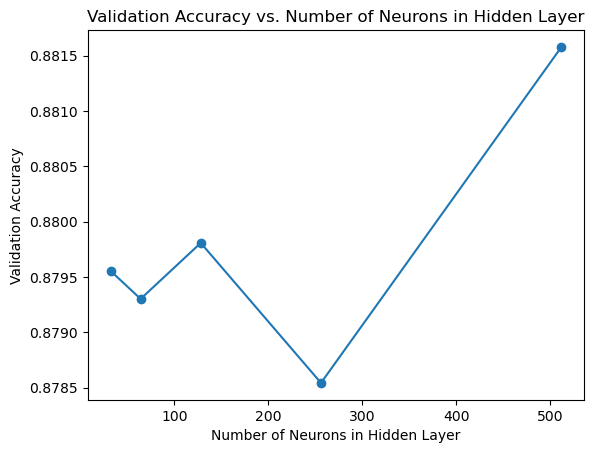

In [6]:
import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense


# It's good practice to scale the input features when using neural networks
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_split.toarray())  # Convert sparse matrix to dense
X_val_scaled = scaler.transform(X_val.toarray())  # Convert sparse matrix to dense

# Neurons to test in the hidden layer
neurons = [32, 64, 128, 256, 512]
validation_accuracies = []

for n in neurons:
    # Define the model
    model = Sequential([
        Dense(n, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(1, activation='sigmoid')
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model
    history = model.fit(X_train_scaled, y_train_split, epochs=10, batch_size=256, validation_data=(X_val_scaled, y_val), verbose=0)
    
    # Store the best validation accuracy
    best_val_acc = max(history.history['val_accuracy'])
    validation_accuracies.append(best_val_acc)
    print(f"Neurons: {n}, Best Validation Accuracy: {best_val_acc:.4f}")

# Plotting the performance
plt.plot(neurons, validation_accuracies, marker='o')
plt.xlabel('Number of Neurons in Hidden Layer')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Number of Neurons in Hidden Layer')
plt.show()


512 neurons offer the best validation accuracy

3) DNN Model

Layers: 1, Best Validation Accuracy: 0.8780
Layers: 2, Best Validation Accuracy: 0.8806
Layers: 3, Best Validation Accuracy: 0.8790
Layers: 4, Best Validation Accuracy: 0.8811
Layers: 5, Best Validation Accuracy: 0.8828


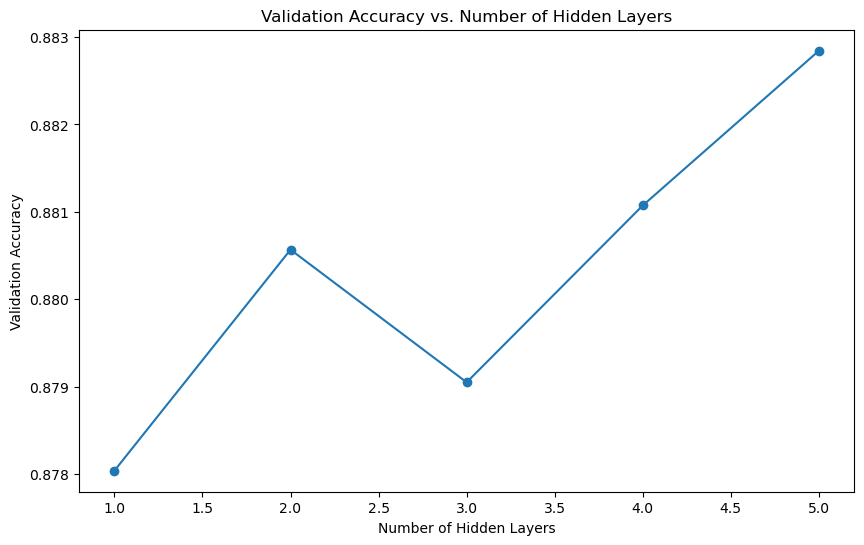

In [7]:
layer_configs = [1, 2, 3, 4, 5]  # Number of hidden layers to test
layer_validation_accuracies = []

for config in layer_configs:
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)))
    for _ in range(1, config):
        model.add(Dense(256, activation='relu'))  # Adding additional layers based on the config
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X_train_scaled, y_train_split, epochs=10, batch_size=256, validation_data=(X_val_scaled, y_val), verbose=0)
    
    best_val_acc = max(history.history['val_accuracy'])
    layer_validation_accuracies.append(best_val_acc)
    print(f"Layers: {config}, Best Validation Accuracy: {best_val_acc:.4f}")

# Plotting the performance for varying layers
plt.figure(figsize=(10, 6))
plt.plot(layer_configs, layer_validation_accuracies, marker='o')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Number of Hidden Layers')
plt.show()


Activation: relu, Best Validation Accuracy: 0.8808
Activation: tanh, Best Validation Accuracy: 0.8790
Activation: sigmoid, Best Validation Accuracy: 0.8806


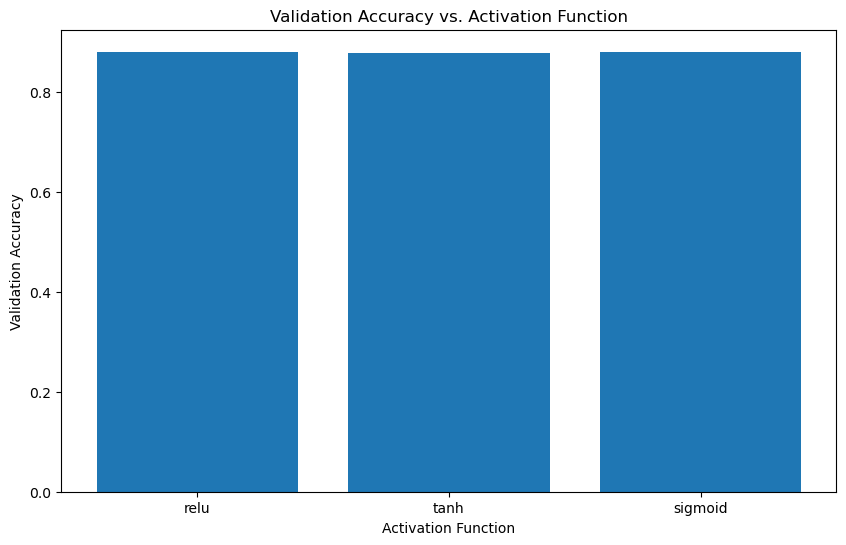

In [8]:
activation_functions = ['relu', 'tanh', 'sigmoid']
activation_validation_accuracies = []

for activation in activation_functions:
    model = Sequential([
        Dense(256, activation=activation, input_shape=(X_train_scaled.shape[1],)),
        Dense(256, activation=activation),
        Dense(256, activation=activation),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X_train_scaled, y_train_split, epochs=10, batch_size=256, validation_data=(X_val_scaled, y_val), verbose=0)
    
    best_val_acc = max(history.history['val_accuracy'])
    activation_validation_accuracies.append(best_val_acc)
    print(f"Activation: {activation}, Best Validation Accuracy: {best_val_acc:.4f}")

# Plotting the performance for varying activation functions
plt.figure(figsize=(10, 6))
plt.bar(activation_functions, activation_validation_accuracies)
plt.xlabel('Activation Function')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Activation Function')
plt.show()


4) Complex NN - LTSM

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences


# Assuming `cleaned_body` is your preprocessed text column
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_df['cleaned_body'])

# Convert texts to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(train_df['cleaned_body'])
X_test_seq = tokenizer.texts_to_sequences(test_df['cleaned_body'])

# Pad sequences to ensure uniform input size
max_length = max([len(x) for x in X_train_seq])  # You might choose a fixed length instead
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')


In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(input_dim=8000, output_dim=32))  # Reduced output_dim
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))  # Reduced units
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Adjust epochs and batch size
model.fit(X_train_padded, y_train, epochs=5, batch_size=128,  # Increased batch size
          validation_split=0.2, verbose=2, callbacks=[early_stopping])

